In [1]:
!pip install wfdb

In [2]:
!pip install PyWavelets

In [3]:
import datetime
import wfdb
from wfdb import get_record_list, dl_database
import pywt
import seaborn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import csv
import pandas as pd
import numpy as np
import re
import glob
import pickle
import copy
from tqdm import tqdm
import ast
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import warnings

In [4]:
!pip install unzip

In [5]:
import zipfile
import os

# Define the path to your ZIP file and the extraction directory
zip_path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip'
extract_path = '/content/ptb-xl'  # Use the appropriate path for your environment

# Create the extraction directory if it does not exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted files to {extract_path}")

Extracted files to /content/ptb-xl


In [6]:
def load_raw_data(df, sampling_rate, path, leads):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path + f) for f in df.filename_hr]

    # Convert to numpy and select only the specified leads (channels)
    data = np.array([signal[:, leads] for signal, meta in data])
    return data

In [7]:
path = '/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

In [8]:
import ast

In [9]:
# Load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Specify the leads to keep  (example: V5 would be lead 11)
leads_to_keep = [11]

# Load raw signal data for the specified leads
X = load_raw_data(Y, sampling_rate, path, leads_to_keep)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [10]:
X.shape

(21799, 1000, 1)

In [11]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [12]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [13]:
# Convert lists to tuples
Y['diagnostic_superclass_tuple'] = Y['diagnostic_superclass'].apply(tuple)

# Get unique tuples
unique_values = Y['diagnostic_superclass_tuple'].unique()
print(unique_values)

[('NORM',) ('MI',) () ('STTC',) ('HYP',) ('CD',) ('MI', 'STTC')
 ('CD', 'HYP') ('MI', 'CD') ('CD', 'STTC') ('MI', 'HYP')
 ('HYP', 'MI', 'STTC') ('STTC', 'MI', 'CD', 'HYP') ('STTC', 'HYP')
 ('CD', 'NORM') ('MI', 'STTC', 'HYP') ('MI', 'CD', 'STTC') ('HYP', 'STTC')
 ('STTC', 'CD', 'HYP') ('HYP', 'CD', 'STTC') ('MI', 'STTC', 'HYP', 'CD')
 ('STTC', 'NORM') ('MI', 'CD', 'HYP') ('HYP', 'MI', 'CD', 'STTC')
 ('CD', 'STTC', 'NORM') ('STTC', 'MI', 'HYP', 'CD') ('CD', 'HYP', 'NORM')
 ('HYP', 'NORM') ('STTC', 'MI', 'HYP') ('MI', 'CD', 'HYP', 'NORM')]


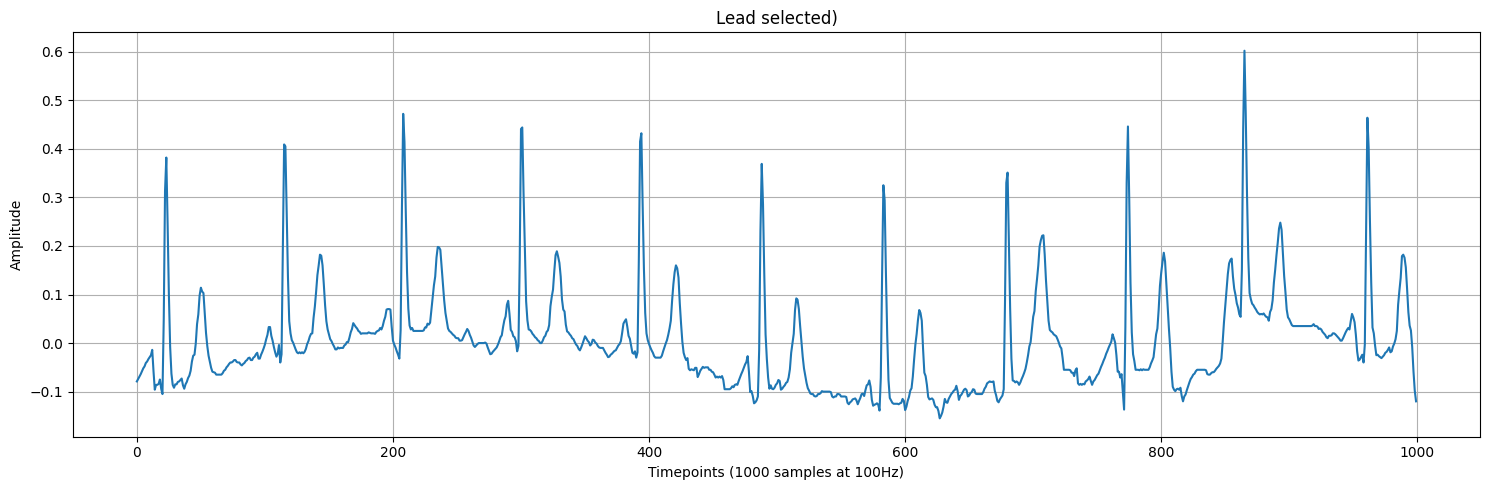

In [14]:
# Select a specific ECG record to visualize
record_index = 0  # Change this index to visualize different records
ecg_signal = X[record_index]  # shape: (1000, 1) for the selected lead(s)

# Plot the selected lead(s)
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal[:, 0])  # Only one channel, so we access column 0
plt.title(f'Lead selected)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.xlabel('Timepoints (1000 samples at 100Hz)')
plt.tight_layout()
plt.show()

In [15]:
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9) #db5 =  Daubechies wavelet w/ 5 coefficients
    #level=9 is how many times the signal is decomposed

    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs #cA = approx. coeff
    #cD = detail coeff.

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold) # sets coefficients below the threshold to zero

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

C:\Users\Mario\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\Mario\anaconda3\lib\site-packages\pywt\_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


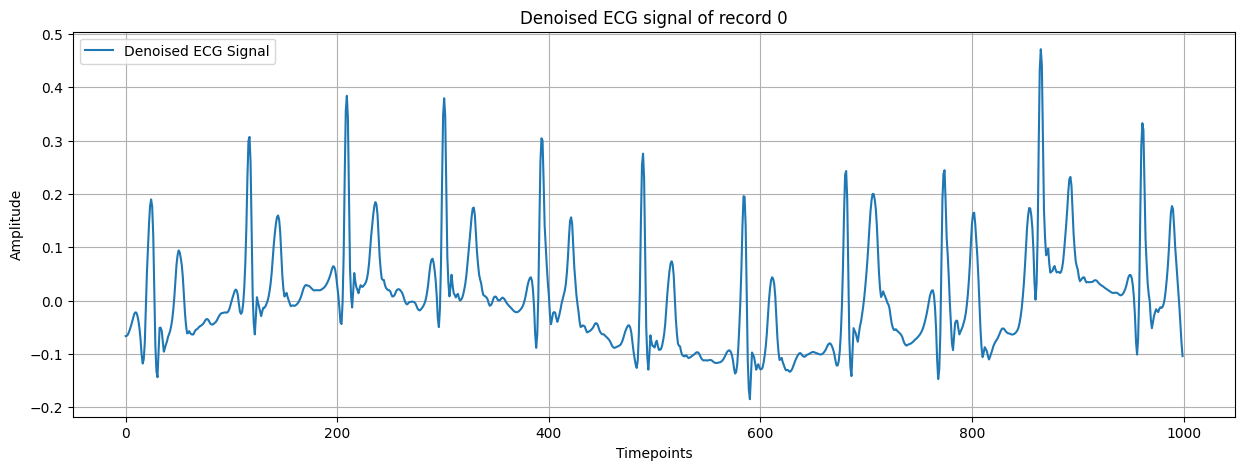

In [16]:
# Assuming X is your ECG signal data with shape (21799, 1000, 1)
# Apply denoising to each record
X_denoised = np.zeros_like(X)

for i in range(X.shape[0]):
    # Extract the signal from the single channel
    signal = X[i, :, 0]
    # Denoise the signal
    denoised_signal = denoise(signal)
    # Store the denoised signal
    X_denoised[i, :, 0] = denoised_signal

# Example of plotting the denoised signal
record_index = 0  # Select the record you want to visualize
plt.figure(figsize=(15, 5))
plt.plot(X_denoised[record_index, :, 0], label='Denoised ECG Signal')
plt.title(f'Denoised ECG signal of record {record_index}')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
#X = X_denoised

In [18]:
import scipy.signal
from collections import deque
from bisect import insort
from warnings import warn

In [19]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def peaks(ecg_signal, sampling_rate):
    # Step 1: Bandpass filtering to remove noise (typically 5-15 Hz)
    b, a = signal.butter(1, [5/(sampling_rate/2), 15/(sampling_rate/2)], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)

    # Step 2: Differentiation (to emphasize the QRS complex)
    diff_ecg = np.diff(filtered_ecg)

    # Step 3: Squaring (to make the result positive and enhance larger values)
    squared_ecg = diff_ecg ** 2

    # Step 4: Moving window integration (to smooth the signal)
    window_size = int(0.12 * sampling_rate)  # 120 ms window
    integrated_ecg = np.convolve(squared_ecg, np.ones(window_size) / window_size, mode='same')

    # Step 5: Peak detection using a threshold
    threshold = 0.6 * np.max(integrated_ecg)
    r_peaks, _ = signal.find_peaks(integrated_ecg, height=threshold, distance=sampling_rate/2)

    return np.array(r_peaks), integrated_ecg

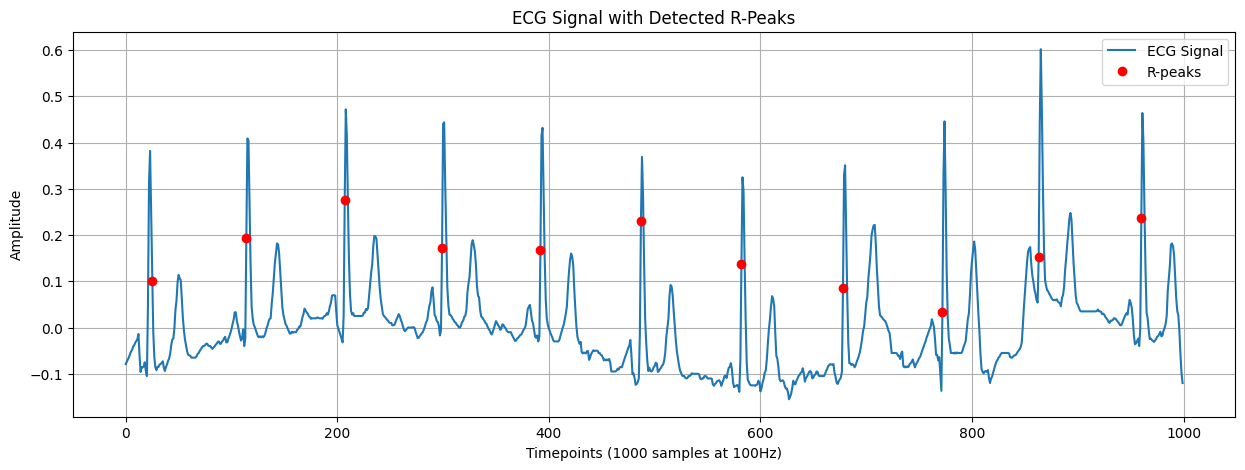

In [20]:
# Example usage:
sampling_rate = 100  # Set to the actual sampling rate of your data
record_index = 0  # Choose a specific record to visualize
ecg_signal = X[record_index, :, 0]  # Use the selected lead (e.g., V5)

# Detect R-peaks
r_peaks, integrated_ecg = peaks(ecg_signal, sampling_rate=sampling_rate)

# Plot the ECG signal with R-peaks
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal, label='ECG Signal')
plt.plot(r_peaks, ecg_signal[r_peaks], 'ro', label='R-peaks')
plt.title('ECG Signal with Detected R-Peaks')
plt.xlabel('Timepoints (1000 samples at 100Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
pre_peak_samples = 150 # samples before the r-peak
post_peak_samples = 200 # samples after the r-peak

In [22]:
def extract_segments_around_peaks(signal, r_peaks, pre_samples, post_samples):
    """Extract segments of the signal around detected R-peaks."""
    segments = []
    for peak in r_peaks:
        start = max(0, peak - pre_samples)
        end = min(len(signal), peak + post_samples)

        # Ensure the segment has the correct length
        if end - start == pre_samples + post_samples:
            segment = signal[start:end]
            segments.append(segment)

    return segments

In [23]:
def find_r_peaks_and_extract_segments(X, Y, sampling_rate, pre_samples, post_samples):
    """Find R-peaks and extract segments for all records."""
    all_segments = []
    all_labels = []

    for record_index in range(X.shape[0]):
        ecg_signal = X[record_index, :, 0]  # Extract the selected lead signal

        # Unpack the r_peaks and ignore the integrated ECG for now
        r_peaks_zong, _ = peaks(ecg_signal, sampling_rate=sampling_rate)  # r peak detection

        # Ensure r_peaks_zong is an array of integers
        r_peaks_zong = r_peaks_zong.astype(int) if len(r_peaks_zong) > 0 else []

        # Extract segments around the R-peaks
        if len(r_peaks_zong) > 0:
            segments = extract_segments_around_peaks(ecg_signal, r_peaks_zong, pre_samples, post_samples)
        else:
            segments = []  # Handle cases where no R-peaks are detected

        # Get the label for the current record
        record_id = Y.index[record_index]
        label = Y.loc[record_id, 'diagnostic_superclass']

        # Convert the label list to a single label (if needed)
        label = label[0] if len(label) > 0 else 0  # Handle empty labels appropriately

        all_segments.extend(segments)
        all_labels.extend([label] * len(segments))  # Assign the same label to all segments from the same record

        print(f"Record {record_index}: Detected {len(r_peaks_zong)} R-peaks and extracted {len(segments)} segments")

    return all_segments, all_labels

In [24]:
# Find R-peaks and extract segments for all records
X_data, Y_data = find_r_peaks_and_extract_segments(X, Y, sampling_rate, pre_peak_samples, post_peak_samples)

Record 0: Detected 11 R-peaks and extracted 7 segments
Record 1: Detected 8 R-peaks and extracted 5 segments
Record 2: Detected 11 R-peaks and extracted 7 segments
Record 3: Detected 13 R-peaks and extracted 8 segments
Record 4: Detected 11 R-peaks and extracted 7 segments
Record 5: Detected 13 R-peaks and extracted 9 segments
Record 6: Detected 10 R-peaks and extracted 6 segments
Record 7: Detected 12 R-peaks and extracted 8 segments
Record 8: Detected 10 R-peaks and extracted 7 segments
Record 9: Detected 11 R-peaks and extracted 7 segments
Record 10: Detected 11 R-peaks and extracted 7 segments
Record 11: Detected 8 R-peaks and extracted 5 segments
Record 12: Detected 13 R-peaks and extracted 8 segments
Record 13: Detected 12 R-peaks and extracted 8 segments
Record 14: Detected 10 R-peaks and extracted 6 segments
Record 15: Detected 14 R-peaks and extracted 9 segments
Record 16: Detected 11 R-peaks and extracted 6 segments
Record 17: Detected 12 R-peaks and extracted 8 segments
Reco

Record 325: Detected 12 R-peaks and extracted 8 segments
Record 326: Detected 10 R-peaks and extracted 6 segments
Record 327: Detected 11 R-peaks and extracted 7 segments
Record 328: Detected 12 R-peaks and extracted 9 segments
Record 329: Detected 14 R-peaks and extracted 9 segments
Record 330: Detected 12 R-peaks and extracted 8 segments
Record 331: Detected 14 R-peaks and extracted 10 segments
Record 332: Detected 12 R-peaks and extracted 8 segments
Record 333: Detected 13 R-peaks and extracted 8 segments
Record 334: Detected 11 R-peaks and extracted 7 segments
Record 335: Detected 12 R-peaks and extracted 8 segments
Record 336: Detected 16 R-peaks and extracted 11 segments
Record 337: Detected 11 R-peaks and extracted 7 segments
Record 338: Detected 16 R-peaks and extracted 11 segments
Record 339: Detected 15 R-peaks and extracted 9 segments
Record 340: Detected 14 R-peaks and extracted 9 segments
Record 341: Detected 12 R-peaks and extracted 7 segments
Record 342: Detected 12 R-pe

Record 652: Detected 12 R-peaks and extracted 7 segments
Record 653: Detected 12 R-peaks and extracted 7 segments
Record 654: Detected 13 R-peaks and extracted 8 segments
Record 655: Detected 12 R-peaks and extracted 8 segments
Record 656: Detected 13 R-peaks and extracted 9 segments
Record 657: Detected 5 R-peaks and extracted 3 segments
Record 658: Detected 13 R-peaks and extracted 8 segments
Record 659: Detected 11 R-peaks and extracted 7 segments
Record 660: Detected 13 R-peaks and extracted 9 segments
Record 661: Detected 1 R-peaks and extracted 1 segments
Record 662: Detected 13 R-peaks and extracted 8 segments
Record 663: Detected 11 R-peaks and extracted 7 segments
Record 664: Detected 11 R-peaks and extracted 7 segments
Record 665: Detected 15 R-peaks and extracted 9 segments
Record 666: Detected 13 R-peaks and extracted 8 segments
Record 667: Detected 13 R-peaks and extracted 8 segments
Record 668: Detected 13 R-peaks and extracted 9 segments
Record 669: Detected 13 R-peaks a

Record 983: Detected 14 R-peaks and extracted 9 segments
Record 984: Detected 9 R-peaks and extracted 7 segments
Record 985: Detected 10 R-peaks and extracted 6 segments
Record 986: Detected 9 R-peaks and extracted 6 segments
Record 987: Detected 10 R-peaks and extracted 6 segments
Record 988: Detected 11 R-peaks and extracted 7 segments
Record 989: Detected 11 R-peaks and extracted 6 segments
Record 990: Detected 14 R-peaks and extracted 9 segments
Record 991: Detected 12 R-peaks and extracted 8 segments
Record 992: Detected 10 R-peaks and extracted 7 segments
Record 993: Detected 8 R-peaks and extracted 6 segments
Record 994: Detected 17 R-peaks and extracted 11 segments
Record 995: Detected 10 R-peaks and extracted 6 segments
Record 996: Detected 11 R-peaks and extracted 7 segments
Record 997: Detected 11 R-peaks and extracted 7 segments
Record 998: Detected 14 R-peaks and extracted 9 segments
Record 999: Detected 6 R-peaks and extracted 3 segments
Record 1000: Detected 11 R-peaks a

Record 1307: Detected 10 R-peaks and extracted 7 segments
Record 1308: Detected 8 R-peaks and extracted 5 segments
Record 1309: Detected 12 R-peaks and extracted 8 segments
Record 1310: Detected 12 R-peaks and extracted 8 segments
Record 1311: Detected 8 R-peaks and extracted 6 segments
Record 1312: Detected 12 R-peaks and extracted 7 segments
Record 1313: Detected 11 R-peaks and extracted 7 segments
Record 1314: Detected 13 R-peaks and extracted 8 segments
Record 1315: Detected 16 R-peaks and extracted 10 segments
Record 1316: Detected 17 R-peaks and extracted 12 segments
Record 1317: Detected 11 R-peaks and extracted 7 segments
Record 1318: Detected 12 R-peaks and extracted 8 segments
Record 1319: Detected 12 R-peaks and extracted 7 segments
Record 1320: Detected 11 R-peaks and extracted 7 segments
Record 1321: Detected 9 R-peaks and extracted 5 segments
Record 1322: Detected 13 R-peaks and extracted 8 segments
Record 1323: Detected 12 R-peaks and extracted 8 segments
Record 1324: De

Record 1639: Detected 10 R-peaks and extracted 6 segments
Record 1640: Detected 11 R-peaks and extracted 8 segments
Record 1641: Detected 8 R-peaks and extracted 6 segments
Record 1642: Detected 11 R-peaks and extracted 7 segments
Record 1643: Detected 9 R-peaks and extracted 6 segments
Record 1644: Detected 15 R-peaks and extracted 10 segments
Record 1645: Detected 8 R-peaks and extracted 5 segments
Record 1646: Detected 9 R-peaks and extracted 5 segments
Record 1647: Detected 10 R-peaks and extracted 7 segments
Record 1648: Detected 16 R-peaks and extracted 10 segments
Record 1649: Detected 11 R-peaks and extracted 7 segments
Record 1650: Detected 11 R-peaks and extracted 8 segments
Record 1651: Detected 10 R-peaks and extracted 7 segments
Record 1652: Detected 13 R-peaks and extracted 8 segments
Record 1653: Detected 10 R-peaks and extracted 7 segments
Record 1654: Detected 11 R-peaks and extracted 7 segments
Record 1655: Detected 13 R-peaks and extracted 9 segments
Record 1656: Det

Record 1974: Detected 13 R-peaks and extracted 9 segments
Record 1975: Detected 13 R-peaks and extracted 9 segments
Record 1976: Detected 8 R-peaks and extracted 6 segments
Record 1977: Detected 13 R-peaks and extracted 8 segments
Record 1978: Detected 10 R-peaks and extracted 6 segments
Record 1979: Detected 11 R-peaks and extracted 7 segments
Record 1980: Detected 11 R-peaks and extracted 7 segments
Record 1981: Detected 13 R-peaks and extracted 9 segments
Record 1982: Detected 14 R-peaks and extracted 9 segments
Record 1983: Detected 11 R-peaks and extracted 8 segments
Record 1984: Detected 9 R-peaks and extracted 6 segments
Record 1985: Detected 15 R-peaks and extracted 10 segments
Record 1986: Detected 9 R-peaks and extracted 6 segments
Record 1987: Detected 12 R-peaks and extracted 8 segments
Record 1988: Detected 12 R-peaks and extracted 8 segments
Record 1989: Detected 11 R-peaks and extracted 7 segments
Record 1990: Detected 11 R-peaks and extracted 7 segments
Record 1991: Det

Record 2310: Detected 11 R-peaks and extracted 8 segments
Record 2311: Detected 10 R-peaks and extracted 6 segments
Record 2312: Detected 11 R-peaks and extracted 7 segments
Record 2313: Detected 12 R-peaks and extracted 8 segments
Record 2314: Detected 13 R-peaks and extracted 8 segments
Record 2315: Detected 10 R-peaks and extracted 7 segments
Record 2316: Detected 8 R-peaks and extracted 6 segments
Record 2317: Detected 12 R-peaks and extracted 7 segments
Record 2318: Detected 10 R-peaks and extracted 6 segments
Record 2319: Detected 12 R-peaks and extracted 8 segments
Record 2320: Detected 13 R-peaks and extracted 8 segments
Record 2321: Detected 11 R-peaks and extracted 7 segments
Record 2322: Detected 11 R-peaks and extracted 7 segments
Record 2323: Detected 13 R-peaks and extracted 8 segments
Record 2324: Detected 12 R-peaks and extracted 8 segments
Record 2325: Detected 10 R-peaks and extracted 7 segments
Record 2326: Detected 8 R-peaks and extracted 6 segments
Record 2327: Det

Record 2644: Detected 10 R-peaks and extracted 7 segments
Record 2645: Detected 12 R-peaks and extracted 8 segments
Record 2646: Detected 11 R-peaks and extracted 7 segments
Record 2647: Detected 13 R-peaks and extracted 8 segments
Record 2648: Detected 10 R-peaks and extracted 6 segments
Record 2649: Detected 13 R-peaks and extracted 8 segments
Record 2650: Detected 9 R-peaks and extracted 6 segments
Record 2651: Detected 15 R-peaks and extracted 10 segments
Record 2652: Detected 12 R-peaks and extracted 8 segments
Record 2653: Detected 12 R-peaks and extracted 8 segments
Record 2654: Detected 13 R-peaks and extracted 8 segments
Record 2655: Detected 15 R-peaks and extracted 10 segments
Record 2656: Detected 10 R-peaks and extracted 6 segments
Record 2657: Detected 11 R-peaks and extracted 8 segments
Record 2658: Detected 11 R-peaks and extracted 7 segments
Record 2659: Detected 10 R-peaks and extracted 7 segments
Record 2660: Detected 15 R-peaks and extracted 10 segments
Record 2661:

Record 2979: Detected 1 R-peaks and extracted 1 segments
Record 2980: Detected 10 R-peaks and extracted 7 segments
Record 2981: Detected 10 R-peaks and extracted 6 segments
Record 2982: Detected 2 R-peaks and extracted 2 segments
Record 2983: Detected 1 R-peaks and extracted 0 segments
Record 2984: Detected 16 R-peaks and extracted 10 segments
Record 2985: Detected 12 R-peaks and extracted 8 segments
Record 2986: Detected 13 R-peaks and extracted 8 segments
Record 2987: Detected 12 R-peaks and extracted 7 segments
Record 2988: Detected 11 R-peaks and extracted 7 segments
Record 2989: Detected 11 R-peaks and extracted 8 segments
Record 2990: Detected 8 R-peaks and extracted 5 segments
Record 2991: Detected 11 R-peaks and extracted 6 segments
Record 2992: Detected 12 R-peaks and extracted 8 segments
Record 2993: Detected 16 R-peaks and extracted 10 segments
Record 2994: Detected 14 R-peaks and extracted 9 segments
Record 2995: Detected 10 R-peaks and extracted 7 segments
Record 2996: Det

Record 3313: Detected 12 R-peaks and extracted 8 segments
Record 3314: Detected 12 R-peaks and extracted 8 segments
Record 3315: Detected 12 R-peaks and extracted 8 segments
Record 3316: Detected 12 R-peaks and extracted 8 segments
Record 3317: Detected 12 R-peaks and extracted 8 segments
Record 3318: Detected 11 R-peaks and extracted 7 segments
Record 3319: Detected 10 R-peaks and extracted 7 segments
Record 3320: Detected 12 R-peaks and extracted 8 segments
Record 3321: Detected 6 R-peaks and extracted 3 segments
Record 3322: Detected 8 R-peaks and extracted 5 segments
Record 3323: Detected 12 R-peaks and extracted 6 segments
Record 3324: Detected 12 R-peaks and extracted 7 segments
Record 3325: Detected 10 R-peaks and extracted 6 segments
Record 3326: Detected 16 R-peaks and extracted 11 segments
Record 3327: Detected 17 R-peaks and extracted 11 segments
Record 3328: Detected 10 R-peaks and extracted 7 segments
Record 3329: Detected 13 R-peaks and extracted 9 segments
Record 3330: D

Record 3632: Detected 10 R-peaks and extracted 7 segments
Record 3633: Detected 9 R-peaks and extracted 6 segments
Record 3634: Detected 9 R-peaks and extracted 6 segments
Record 3635: Detected 13 R-peaks and extracted 8 segments
Record 3636: Detected 12 R-peaks and extracted 8 segments
Record 3637: Detected 11 R-peaks and extracted 7 segments
Record 3638: Detected 12 R-peaks and extracted 7 segments
Record 3639: Detected 10 R-peaks and extracted 8 segments
Record 3640: Detected 11 R-peaks and extracted 7 segments
Record 3641: Detected 13 R-peaks and extracted 9 segments
Record 3642: Detected 11 R-peaks and extracted 7 segments
Record 3643: Detected 14 R-peaks and extracted 9 segments
Record 3644: Detected 8 R-peaks and extracted 6 segments
Record 3645: Detected 12 R-peaks and extracted 7 segments
Record 3646: Detected 10 R-peaks and extracted 7 segments
Record 3647: Detected 15 R-peaks and extracted 10 segments
Record 3648: Detected 14 R-peaks and extracted 10 segments
Record 3649: De

Record 3955: Detected 10 R-peaks and extracted 7 segments
Record 3956: Detected 11 R-peaks and extracted 7 segments
Record 3957: Detected 11 R-peaks and extracted 7 segments
Record 3958: Detected 12 R-peaks and extracted 8 segments
Record 3959: Detected 13 R-peaks and extracted 8 segments
Record 3960: Detected 13 R-peaks and extracted 9 segments
Record 3961: Detected 10 R-peaks and extracted 7 segments
Record 3962: Detected 14 R-peaks and extracted 9 segments
Record 3963: Detected 6 R-peaks and extracted 4 segments
Record 3964: Detected 8 R-peaks and extracted 6 segments
Record 3965: Detected 9 R-peaks and extracted 7 segments
Record 3966: Detected 11 R-peaks and extracted 7 segments
Record 3967: Detected 14 R-peaks and extracted 10 segments
Record 3968: Detected 12 R-peaks and extracted 8 segments
Record 3969: Detected 9 R-peaks and extracted 6 segments
Record 3970: Detected 3 R-peaks and extracted 2 segments
Record 3971: Detected 7 R-peaks and extracted 4 segments
Record 3972: Detect

Record 4286: Detected 1 R-peaks and extracted 1 segments
Record 4287: Detected 12 R-peaks and extracted 8 segments
Record 4288: Detected 13 R-peaks and extracted 9 segments
Record 4289: Detected 14 R-peaks and extracted 9 segments
Record 4290: Detected 15 R-peaks and extracted 10 segments
Record 4291: Detected 14 R-peaks and extracted 8 segments
Record 4292: Detected 11 R-peaks and extracted 7 segments
Record 4293: Detected 10 R-peaks and extracted 6 segments
Record 4294: Detected 13 R-peaks and extracted 9 segments
Record 4295: Detected 11 R-peaks and extracted 8 segments
Record 4296: Detected 10 R-peaks and extracted 6 segments
Record 4297: Detected 12 R-peaks and extracted 7 segments
Record 4298: Detected 9 R-peaks and extracted 6 segments
Record 4299: Detected 12 R-peaks and extracted 8 segments
Record 4300: Detected 13 R-peaks and extracted 9 segments
Record 4301: Detected 15 R-peaks and extracted 10 segments
Record 4302: Detected 3 R-peaks and extracted 2 segments
Record 4303: De

Record 4618: Detected 18 R-peaks and extracted 13 segments
Record 4619: Detected 12 R-peaks and extracted 8 segments
Record 4620: Detected 14 R-peaks and extracted 9 segments
Record 4621: Detected 14 R-peaks and extracted 10 segments
Record 4622: Detected 13 R-peaks and extracted 8 segments
Record 4623: Detected 14 R-peaks and extracted 9 segments
Record 4624: Detected 10 R-peaks and extracted 7 segments
Record 4625: Detected 9 R-peaks and extracted 6 segments
Record 4626: Detected 17 R-peaks and extracted 10 segments
Record 4627: Detected 10 R-peaks and extracted 6 segments
Record 4628: Detected 11 R-peaks and extracted 8 segments
Record 4629: Detected 12 R-peaks and extracted 8 segments
Record 4630: Detected 9 R-peaks and extracted 6 segments
Record 4631: Detected 10 R-peaks and extracted 7 segments
Record 4632: Detected 15 R-peaks and extracted 10 segments
Record 4633: Detected 12 R-peaks and extracted 8 segments
Record 4634: Detected 15 R-peaks and extracted 10 segments
Record 4635

Record 4948: Detected 12 R-peaks and extracted 8 segments
Record 4949: Detected 11 R-peaks and extracted 8 segments
Record 4950: Detected 14 R-peaks and extracted 9 segments
Record 4951: Detected 11 R-peaks and extracted 8 segments
Record 4952: Detected 14 R-peaks and extracted 9 segments
Record 4953: Detected 14 R-peaks and extracted 9 segments
Record 4954: Detected 10 R-peaks and extracted 6 segments
Record 4955: Detected 11 R-peaks and extracted 8 segments
Record 4956: Detected 12 R-peaks and extracted 8 segments
Record 4957: Detected 10 R-peaks and extracted 6 segments
Record 4958: Detected 11 R-peaks and extracted 8 segments
Record 4959: Detected 11 R-peaks and extracted 7 segments
Record 4960: Detected 12 R-peaks and extracted 7 segments
Record 4961: Detected 8 R-peaks and extracted 5 segments
Record 4962: Detected 10 R-peaks and extracted 6 segments
Record 4963: Detected 9 R-peaks and extracted 6 segments
Record 4964: Detected 11 R-peaks and extracted 7 segments
Record 4965: Det

Record 5271: Detected 11 R-peaks and extracted 8 segments
Record 5272: Detected 2 R-peaks and extracted 2 segments
Record 5273: Detected 14 R-peaks and extracted 10 segments
Record 5274: Detected 13 R-peaks and extracted 9 segments
Record 5275: Detected 10 R-peaks and extracted 6 segments
Record 5276: Detected 8 R-peaks and extracted 5 segments
Record 5277: Detected 12 R-peaks and extracted 8 segments
Record 5278: Detected 10 R-peaks and extracted 7 segments
Record 5279: Detected 14 R-peaks and extracted 9 segments
Record 5280: Detected 8 R-peaks and extracted 6 segments
Record 5281: Detected 11 R-peaks and extracted 7 segments
Record 5282: Detected 9 R-peaks and extracted 7 segments
Record 5283: Detected 12 R-peaks and extracted 8 segments
Record 5284: Detected 10 R-peaks and extracted 7 segments
Record 5285: Detected 10 R-peaks and extracted 7 segments
Record 5286: Detected 15 R-peaks and extracted 9 segments
Record 5287: Detected 12 R-peaks and extracted 8 segments
Record 5288: Dete

Record 5529: Detected 10 R-peaks and extracted 6 segments
Record 5530: Detected 10 R-peaks and extracted 7 segments
Record 5531: Detected 14 R-peaks and extracted 9 segments
Record 5532: Detected 12 R-peaks and extracted 7 segments
Record 5533: Detected 7 R-peaks and extracted 3 segments
Record 5534: Detected 11 R-peaks and extracted 7 segments
Record 5535: Detected 14 R-peaks and extracted 9 segments
Record 5536: Detected 12 R-peaks and extracted 8 segments
Record 5537: Detected 14 R-peaks and extracted 10 segments
Record 5538: Detected 10 R-peaks and extracted 7 segments
Record 5539: Detected 13 R-peaks and extracted 8 segments
Record 5540: Detected 14 R-peaks and extracted 8 segments
Record 5541: Detected 10 R-peaks and extracted 7 segments
Record 5542: Detected 9 R-peaks and extracted 5 segments
Record 5543: Detected 10 R-peaks and extracted 6 segments
Record 5544: Detected 11 R-peaks and extracted 7 segments
Record 5545: Detected 12 R-peaks and extracted 7 segments
Record 5546: De

Record 5852: Detected 14 R-peaks and extracted 9 segments
Record 5853: Detected 12 R-peaks and extracted 7 segments
Record 5854: Detected 8 R-peaks and extracted 6 segments
Record 5855: Detected 15 R-peaks and extracted 10 segments
Record 5856: Detected 12 R-peaks and extracted 8 segments
Record 5857: Detected 5 R-peaks and extracted 3 segments
Record 5858: Detected 8 R-peaks and extracted 6 segments
Record 5859: Detected 10 R-peaks and extracted 6 segments
Record 5860: Detected 10 R-peaks and extracted 7 segments
Record 5861: Detected 12 R-peaks and extracted 8 segments
Record 5862: Detected 12 R-peaks and extracted 8 segments
Record 5863: Detected 16 R-peaks and extracted 10 segments
Record 5864: Detected 12 R-peaks and extracted 8 segments
Record 5865: Detected 10 R-peaks and extracted 7 segments
Record 5866: Detected 9 R-peaks and extracted 5 segments
Record 5867: Detected 11 R-peaks and extracted 7 segments
Record 5868: Detected 9 R-peaks and extracted 6 segments
Record 5869: Dete

Record 6166: Detected 12 R-peaks and extracted 8 segments
Record 6167: Detected 12 R-peaks and extracted 9 segments
Record 6168: Detected 5 R-peaks and extracted 4 segments
Record 6169: Detected 11 R-peaks and extracted 7 segments
Record 6170: Detected 12 R-peaks and extracted 8 segments
Record 6171: Detected 13 R-peaks and extracted 8 segments
Record 6172: Detected 14 R-peaks and extracted 9 segments
Record 6173: Detected 16 R-peaks and extracted 10 segments
Record 6174: Detected 4 R-peaks and extracted 1 segments
Record 6175: Detected 9 R-peaks and extracted 6 segments
Record 6176: Detected 12 R-peaks and extracted 7 segments
Record 6177: Detected 8 R-peaks and extracted 6 segments
Record 6178: Detected 10 R-peaks and extracted 7 segments
Record 6179: Detected 10 R-peaks and extracted 6 segments
Record 6180: Detected 11 R-peaks and extracted 7 segments
Record 6181: Detected 8 R-peaks and extracted 5 segments
Record 6182: Detected 13 R-peaks and extracted 8 segments
Record 6183: Detec

Record 6489: Detected 13 R-peaks and extracted 8 segments
Record 6490: Detected 12 R-peaks and extracted 8 segments
Record 6491: Detected 10 R-peaks and extracted 7 segments
Record 6492: Detected 9 R-peaks and extracted 6 segments
Record 6493: Detected 11 R-peaks and extracted 7 segments
Record 6494: Detected 13 R-peaks and extracted 9 segments
Record 6495: Detected 10 R-peaks and extracted 7 segments
Record 6496: Detected 1 R-peaks and extracted 1 segments
Record 6497: Detected 13 R-peaks and extracted 8 segments
Record 6498: Detected 11 R-peaks and extracted 7 segments
Record 6499: Detected 13 R-peaks and extracted 8 segments
Record 6500: Detected 16 R-peaks and extracted 9 segments
Record 6501: Detected 13 R-peaks and extracted 8 segments
Record 6502: Detected 11 R-peaks and extracted 7 segments
Record 6503: Detected 16 R-peaks and extracted 11 segments
Record 6504: Detected 15 R-peaks and extracted 10 segments
Record 6505: Detected 12 R-peaks and extracted 8 segments
Record 6506: D

Record 6811: Detected 14 R-peaks and extracted 10 segments
Record 6812: Detected 15 R-peaks and extracted 10 segments
Record 6813: Detected 10 R-peaks and extracted 7 segments
Record 6814: Detected 15 R-peaks and extracted 9 segments
Record 6815: Detected 13 R-peaks and extracted 8 segments
Record 6816: Detected 13 R-peaks and extracted 8 segments
Record 6817: Detected 17 R-peaks and extracted 11 segments
Record 6818: Detected 9 R-peaks and extracted 6 segments
Record 6819: Detected 8 R-peaks and extracted 6 segments
Record 6820: Detected 12 R-peaks and extracted 8 segments
Record 6821: Detected 8 R-peaks and extracted 6 segments
Record 6822: Detected 10 R-peaks and extracted 6 segments
Record 6823: Detected 12 R-peaks and extracted 7 segments
Record 6824: Detected 11 R-peaks and extracted 8 segments
Record 6825: Detected 15 R-peaks and extracted 10 segments
Record 6826: Detected 13 R-peaks and extracted 9 segments
Record 6827: Detected 16 R-peaks and extracted 11 segments
Record 6828:

Record 7138: Detected 9 R-peaks and extracted 6 segments
Record 7139: Detected 15 R-peaks and extracted 11 segments
Record 7140: Detected 8 R-peaks and extracted 5 segments
Record 7141: Detected 13 R-peaks and extracted 8 segments
Record 7142: Detected 10 R-peaks and extracted 7 segments
Record 7143: Detected 11 R-peaks and extracted 8 segments
Record 7144: Detected 11 R-peaks and extracted 7 segments
Record 7145: Detected 15 R-peaks and extracted 10 segments
Record 7146: Detected 12 R-peaks and extracted 7 segments
Record 7147: Detected 12 R-peaks and extracted 7 segments
Record 7148: Detected 15 R-peaks and extracted 10 segments
Record 7149: Detected 10 R-peaks and extracted 7 segments
Record 7150: Detected 1 R-peaks and extracted 0 segments
Record 7151: Detected 12 R-peaks and extracted 8 segments
Record 7152: Detected 17 R-peaks and extracted 11 segments
Record 7153: Detected 11 R-peaks and extracted 8 segments
Record 7154: Detected 13 R-peaks and extracted 8 segments
Record 7155: 

Record 7521: Detected 12 R-peaks and extracted 7 segments
Record 7522: Detected 18 R-peaks and extracted 11 segments
Record 7523: Detected 11 R-peaks and extracted 7 segments
Record 7524: Detected 11 R-peaks and extracted 7 segments
Record 7525: Detected 9 R-peaks and extracted 5 segments
Record 7526: Detected 17 R-peaks and extracted 11 segments
Record 7527: Detected 12 R-peaks and extracted 8 segments
Record 7528: Detected 13 R-peaks and extracted 9 segments
Record 7529: Detected 13 R-peaks and extracted 8 segments
Record 7530: Detected 16 R-peaks and extracted 10 segments
Record 7531: Detected 11 R-peaks and extracted 8 segments
Record 7532: Detected 11 R-peaks and extracted 7 segments
Record 7533: Detected 11 R-peaks and extracted 7 segments
Record 7534: Detected 14 R-peaks and extracted 9 segments
Record 7535: Detected 9 R-peaks and extracted 5 segments
Record 7536: Detected 13 R-peaks and extracted 8 segments
Record 7537: Detected 11 R-peaks and extracted 8 segments
Record 7538: 

Record 7850: Detected 12 R-peaks and extracted 8 segments
Record 7851: Detected 11 R-peaks and extracted 8 segments
Record 7852: Detected 1 R-peaks and extracted 1 segments
Record 7853: Detected 10 R-peaks and extracted 6 segments
Record 7854: Detected 11 R-peaks and extracted 7 segments
Record 7855: Detected 12 R-peaks and extracted 8 segments
Record 7856: Detected 10 R-peaks and extracted 6 segments
Record 7857: Detected 13 R-peaks and extracted 8 segments
Record 7858: Detected 11 R-peaks and extracted 8 segments
Record 7859: Detected 12 R-peaks and extracted 8 segments
Record 7860: Detected 13 R-peaks and extracted 9 segments
Record 7861: Detected 13 R-peaks and extracted 9 segments
Record 7862: Detected 13 R-peaks and extracted 9 segments
Record 7863: Detected 11 R-peaks and extracted 6 segments
Record 7864: Detected 12 R-peaks and extracted 7 segments
Record 7865: Detected 12 R-peaks and extracted 8 segments
Record 7866: Detected 11 R-peaks and extracted 8 segments
Record 7867: De

Record 8178: Detected 11 R-peaks and extracted 7 segments
Record 8179: Detected 10 R-peaks and extracted 7 segments
Record 8180: Detected 9 R-peaks and extracted 6 segments
Record 8181: Detected 11 R-peaks and extracted 8 segments
Record 8182: Detected 13 R-peaks and extracted 9 segments
Record 8183: Detected 11 R-peaks and extracted 7 segments
Record 8184: Detected 14 R-peaks and extracted 9 segments
Record 8185: Detected 14 R-peaks and extracted 10 segments
Record 8186: Detected 9 R-peaks and extracted 5 segments
Record 8187: Detected 11 R-peaks and extracted 7 segments
Record 8188: Detected 11 R-peaks and extracted 7 segments
Record 8189: Detected 10 R-peaks and extracted 7 segments
Record 8190: Detected 10 R-peaks and extracted 7 segments
Record 8191: Detected 14 R-peaks and extracted 9 segments
Record 8192: Detected 12 R-peaks and extracted 7 segments
Record 8193: Detected 10 R-peaks and extracted 6 segments
Record 8194: Detected 13 R-peaks and extracted 9 segments
Record 8195: De

Record 8532: Detected 15 R-peaks and extracted 10 segments
Record 8533: Detected 14 R-peaks and extracted 9 segments
Record 8534: Detected 12 R-peaks and extracted 8 segments
Record 8535: Detected 12 R-peaks and extracted 9 segments
Record 8536: Detected 11 R-peaks and extracted 7 segments
Record 8537: Detected 10 R-peaks and extracted 7 segments
Record 8538: Detected 14 R-peaks and extracted 10 segments
Record 8539: Detected 10 R-peaks and extracted 7 segments
Record 8540: Detected 9 R-peaks and extracted 6 segments
Record 8541: Detected 11 R-peaks and extracted 7 segments
Record 8542: Detected 8 R-peaks and extracted 6 segments
Record 8543: Detected 12 R-peaks and extracted 8 segments
Record 8544: Detected 18 R-peaks and extracted 12 segments
Record 8545: Detected 10 R-peaks and extracted 6 segments
Record 8546: Detected 12 R-peaks and extracted 8 segments
Record 8547: Detected 9 R-peaks and extracted 5 segments
Record 8548: Detected 11 R-peaks and extracted 8 segments
Record 8549: D

Record 8858: Detected 15 R-peaks and extracted 10 segments
Record 8859: Detected 7 R-peaks and extracted 6 segments
Record 8860: Detected 10 R-peaks and extracted 6 segments
Record 8861: Detected 11 R-peaks and extracted 8 segments
Record 8862: Detected 10 R-peaks and extracted 7 segments
Record 8863: Detected 12 R-peaks and extracted 7 segments
Record 8864: Detected 11 R-peaks and extracted 7 segments
Record 8865: Detected 13 R-peaks and extracted 9 segments
Record 8866: Detected 14 R-peaks and extracted 9 segments
Record 8867: Detected 12 R-peaks and extracted 8 segments
Record 8868: Detected 9 R-peaks and extracted 6 segments
Record 8869: Detected 6 R-peaks and extracted 4 segments
Record 8870: Detected 9 R-peaks and extracted 6 segments
Record 8871: Detected 18 R-peaks and extracted 12 segments
Record 8872: Detected 11 R-peaks and extracted 8 segments
Record 8873: Detected 14 R-peaks and extracted 9 segments
Record 8874: Detected 14 R-peaks and extracted 9 segments
Record 8875: Det

Record 9185: Detected 11 R-peaks and extracted 7 segments
Record 9186: Detected 14 R-peaks and extracted 9 segments
Record 9187: Detected 9 R-peaks and extracted 6 segments
Record 9188: Detected 1 R-peaks and extracted 1 segments
Record 9189: Detected 13 R-peaks and extracted 8 segments
Record 9190: Detected 15 R-peaks and extracted 10 segments
Record 9191: Detected 15 R-peaks and extracted 10 segments
Record 9192: Detected 10 R-peaks and extracted 6 segments
Record 9193: Detected 6 R-peaks and extracted 4 segments
Record 9194: Detected 12 R-peaks and extracted 8 segments
Record 9195: Detected 11 R-peaks and extracted 8 segments
Record 9196: Detected 1 R-peaks and extracted 1 segments
Record 9197: Detected 12 R-peaks and extracted 7 segments
Record 9198: Detected 12 R-peaks and extracted 8 segments
Record 9199: Detected 14 R-peaks and extracted 9 segments
Record 9200: Detected 11 R-peaks and extracted 7 segments
Record 9201: Detected 12 R-peaks and extracted 7 segments
Record 9202: Det

Record 9504: Detected 17 R-peaks and extracted 10 segments
Record 9505: Detected 14 R-peaks and extracted 9 segments
Record 9506: Detected 8 R-peaks and extracted 5 segments
Record 9507: Detected 9 R-peaks and extracted 6 segments
Record 9508: Detected 9 R-peaks and extracted 7 segments
Record 9509: Detected 9 R-peaks and extracted 6 segments
Record 9510: Detected 14 R-peaks and extracted 10 segments
Record 9511: Detected 10 R-peaks and extracted 7 segments
Record 9512: Detected 7 R-peaks and extracted 5 segments
Record 9513: Detected 16 R-peaks and extracted 10 segments
Record 9514: Detected 11 R-peaks and extracted 8 segments
Record 9515: Detected 10 R-peaks and extracted 7 segments
Record 9516: Detected 15 R-peaks and extracted 9 segments
Record 9517: Detected 13 R-peaks and extracted 9 segments
Record 9518: Detected 12 R-peaks and extracted 8 segments
Record 9519: Detected 12 R-peaks and extracted 8 segments
Record 9520: Detected 10 R-peaks and extracted 8 segments
Record 9521: Det

Record 9828: Detected 10 R-peaks and extracted 7 segments
Record 9829: Detected 9 R-peaks and extracted 6 segments
Record 9830: Detected 10 R-peaks and extracted 7 segments
Record 9831: Detected 8 R-peaks and extracted 6 segments
Record 9832: Detected 10 R-peaks and extracted 7 segments
Record 9833: Detected 14 R-peaks and extracted 9 segments
Record 9834: Detected 14 R-peaks and extracted 9 segments
Record 9835: Detected 14 R-peaks and extracted 9 segments
Record 9836: Detected 13 R-peaks and extracted 9 segments
Record 9837: Detected 11 R-peaks and extracted 7 segments
Record 9838: Detected 1 R-peaks and extracted 1 segments
Record 9839: Detected 9 R-peaks and extracted 6 segments
Record 9840: Detected 12 R-peaks and extracted 8 segments
Record 9841: Detected 11 R-peaks and extracted 8 segments
Record 9842: Detected 11 R-peaks and extracted 7 segments
Record 9843: Detected 12 R-peaks and extracted 8 segments
Record 9844: Detected 10 R-peaks and extracted 6 segments
Record 9845: Detec

Record 10144: Detected 15 R-peaks and extracted 10 segments
Record 10145: Detected 10 R-peaks and extracted 6 segments
Record 10146: Detected 14 R-peaks and extracted 9 segments
Record 10147: Detected 15 R-peaks and extracted 11 segments
Record 10148: Detected 15 R-peaks and extracted 10 segments
Record 10149: Detected 10 R-peaks and extracted 7 segments
Record 10150: Detected 14 R-peaks and extracted 9 segments
Record 10151: Detected 9 R-peaks and extracted 6 segments
Record 10152: Detected 13 R-peaks and extracted 8 segments
Record 10153: Detected 10 R-peaks and extracted 7 segments
Record 10154: Detected 9 R-peaks and extracted 6 segments
Record 10155: Detected 11 R-peaks and extracted 8 segments
Record 10156: Detected 13 R-peaks and extracted 8 segments
Record 10157: Detected 12 R-peaks and extracted 7 segments
Record 10158: Detected 9 R-peaks and extracted 6 segments
Record 10159: Detected 12 R-peaks and extracted 8 segments
Record 10160: Detected 13 R-peaks and extracted 8 segmen

Record 10471: Detected 14 R-peaks and extracted 9 segments
Record 10472: Detected 11 R-peaks and extracted 8 segments
Record 10473: Detected 2 R-peaks and extracted 1 segments
Record 10474: Detected 10 R-peaks and extracted 7 segments
Record 10475: Detected 12 R-peaks and extracted 7 segments
Record 10476: Detected 12 R-peaks and extracted 9 segments
Record 10477: Detected 10 R-peaks and extracted 6 segments
Record 10478: Detected 8 R-peaks and extracted 5 segments
Record 10479: Detected 3 R-peaks and extracted 3 segments
Record 10480: Detected 11 R-peaks and extracted 7 segments
Record 10481: Detected 9 R-peaks and extracted 6 segments
Record 10482: Detected 12 R-peaks and extracted 7 segments
Record 10483: Detected 18 R-peaks and extracted 12 segments
Record 10484: Detected 10 R-peaks and extracted 6 segments
Record 10485: Detected 14 R-peaks and extracted 9 segments
Record 10486: Detected 12 R-peaks and extracted 8 segments
Record 10487: Detected 12 R-peaks and extracted 8 segments


Record 10803: Detected 10 R-peaks and extracted 6 segments
Record 10804: Detected 14 R-peaks and extracted 9 segments
Record 10805: Detected 13 R-peaks and extracted 8 segments
Record 10806: Detected 8 R-peaks and extracted 5 segments
Record 10807: Detected 10 R-peaks and extracted 6 segments
Record 10808: Detected 9 R-peaks and extracted 6 segments
Record 10809: Detected 9 R-peaks and extracted 6 segments
Record 10810: Detected 12 R-peaks and extracted 8 segments
Record 10811: Detected 10 R-peaks and extracted 6 segments
Record 10812: Detected 12 R-peaks and extracted 8 segments
Record 10813: Detected 10 R-peaks and extracted 6 segments
Record 10814: Detected 13 R-peaks and extracted 9 segments
Record 10815: Detected 15 R-peaks and extracted 10 segments
Record 10816: Detected 11 R-peaks and extracted 7 segments
Record 10817: Detected 12 R-peaks and extracted 8 segments
Record 10818: Detected 11 R-peaks and extracted 7 segments
Record 10819: Detected 1 R-peaks and extracted 0 segments


Record 11151: Detected 11 R-peaks and extracted 7 segments
Record 11152: Detected 13 R-peaks and extracted 9 segments
Record 11153: Detected 12 R-peaks and extracted 7 segments
Record 11154: Detected 9 R-peaks and extracted 6 segments
Record 11155: Detected 15 R-peaks and extracted 10 segments
Record 11156: Detected 6 R-peaks and extracted 3 segments
Record 11157: Detected 10 R-peaks and extracted 7 segments
Record 11158: Detected 7 R-peaks and extracted 4 segments
Record 11159: Detected 15 R-peaks and extracted 10 segments
Record 11160: Detected 8 R-peaks and extracted 6 segments
Record 11161: Detected 12 R-peaks and extracted 7 segments
Record 11162: Detected 16 R-peaks and extracted 10 segments
Record 11163: Detected 13 R-peaks and extracted 8 segments
Record 11164: Detected 13 R-peaks and extracted 8 segments
Record 11165: Detected 11 R-peaks and extracted 8 segments
Record 11166: Detected 11 R-peaks and extracted 8 segments
Record 11167: Detected 12 R-peaks and extracted 8 segment

Record 11510: Detected 18 R-peaks and extracted 11 segments
Record 11511: Detected 13 R-peaks and extracted 7 segments
Record 11512: Detected 11 R-peaks and extracted 7 segments
Record 11513: Detected 12 R-peaks and extracted 8 segments
Record 11514: Detected 11 R-peaks and extracted 8 segments
Record 11515: Detected 15 R-peaks and extracted 10 segments
Record 11516: Detected 11 R-peaks and extracted 7 segments
Record 11517: Detected 8 R-peaks and extracted 6 segments
Record 11518: Detected 14 R-peaks and extracted 9 segments
Record 11519: Detected 13 R-peaks and extracted 9 segments
Record 11520: Detected 13 R-peaks and extracted 9 segments
Record 11521: Detected 11 R-peaks and extracted 7 segments
Record 11522: Detected 16 R-peaks and extracted 11 segments
Record 11523: Detected 1 R-peaks and extracted 0 segments
Record 11524: Detected 7 R-peaks and extracted 5 segments
Record 11525: Detected 11 R-peaks and extracted 8 segments
Record 11526: Detected 12 R-peaks and extracted 7 segmen

Record 11836: Detected 9 R-peaks and extracted 5 segments
Record 11837: Detected 5 R-peaks and extracted 4 segments
Record 11838: Detected 9 R-peaks and extracted 6 segments
Record 11839: Detected 12 R-peaks and extracted 8 segments
Record 11840: Detected 9 R-peaks and extracted 7 segments
Record 11841: Detected 9 R-peaks and extracted 5 segments
Record 11842: Detected 11 R-peaks and extracted 8 segments
Record 11843: Detected 15 R-peaks and extracted 10 segments
Record 11844: Detected 9 R-peaks and extracted 6 segments
Record 11845: Detected 8 R-peaks and extracted 5 segments
Record 11846: Detected 13 R-peaks and extracted 8 segments
Record 11847: Detected 9 R-peaks and extracted 7 segments
Record 11848: Detected 9 R-peaks and extracted 6 segments
Record 11849: Detected 9 R-peaks and extracted 6 segments
Record 11850: Detected 10 R-peaks and extracted 7 segments
Record 11851: Detected 10 R-peaks and extracted 7 segments
Record 11852: Detected 12 R-peaks and extracted 7 segments
Record

Record 12213: Detected 4 R-peaks and extracted 2 segments
Record 12214: Detected 11 R-peaks and extracted 7 segments
Record 12215: Detected 9 R-peaks and extracted 6 segments
Record 12216: Detected 13 R-peaks and extracted 9 segments
Record 12217: Detected 12 R-peaks and extracted 7 segments
Record 12218: Detected 13 R-peaks and extracted 9 segments
Record 12219: Detected 12 R-peaks and extracted 9 segments
Record 12220: Detected 11 R-peaks and extracted 7 segments
Record 12221: Detected 8 R-peaks and extracted 4 segments
Record 12222: Detected 12 R-peaks and extracted 7 segments
Record 12223: Detected 8 R-peaks and extracted 4 segments
Record 12224: Detected 14 R-peaks and extracted 9 segments
Record 12225: Detected 12 R-peaks and extracted 8 segments
Record 12226: Detected 13 R-peaks and extracted 9 segments
Record 12227: Detected 6 R-peaks and extracted 5 segments
Record 12228: Detected 11 R-peaks and extracted 7 segments
Record 12229: Detected 12 R-peaks and extracted 7 segments
Re

Record 12562: Detected 11 R-peaks and extracted 7 segments
Record 12563: Detected 10 R-peaks and extracted 6 segments
Record 12564: Detected 10 R-peaks and extracted 8 segments
Record 12565: Detected 10 R-peaks and extracted 6 segments
Record 12566: Detected 10 R-peaks and extracted 7 segments
Record 12567: Detected 9 R-peaks and extracted 6 segments
Record 12568: Detected 11 R-peaks and extracted 7 segments
Record 12569: Detected 15 R-peaks and extracted 9 segments
Record 12570: Detected 16 R-peaks and extracted 10 segments
Record 12571: Detected 12 R-peaks and extracted 8 segments
Record 12572: Detected 11 R-peaks and extracted 7 segments
Record 12573: Detected 13 R-peaks and extracted 8 segments
Record 12574: Detected 11 R-peaks and extracted 8 segments
Record 12575: Detected 12 R-peaks and extracted 8 segments
Record 12576: Detected 11 R-peaks and extracted 7 segments
Record 12577: Detected 3 R-peaks and extracted 3 segments
Record 12578: Detected 11 R-peaks and extracted 8 segment

Record 12885: Detected 11 R-peaks and extracted 8 segments
Record 12886: Detected 12 R-peaks and extracted 8 segments
Record 12887: Detected 10 R-peaks and extracted 6 segments
Record 12888: Detected 10 R-peaks and extracted 7 segments
Record 12889: Detected 9 R-peaks and extracted 6 segments
Record 12890: Detected 12 R-peaks and extracted 8 segments
Record 12891: Detected 12 R-peaks and extracted 7 segments
Record 12892: Detected 2 R-peaks and extracted 2 segments
Record 12893: Detected 13 R-peaks and extracted 8 segments
Record 12894: Detected 18 R-peaks and extracted 12 segments
Record 12895: Detected 11 R-peaks and extracted 7 segments
Record 12896: Detected 11 R-peaks and extracted 7 segments
Record 12897: Detected 10 R-peaks and extracted 6 segments
Record 12898: Detected 7 R-peaks and extracted 4 segments
Record 12899: Detected 13 R-peaks and extracted 9 segments
Record 12900: Detected 17 R-peaks and extracted 11 segments
Record 12901: Detected 10 R-peaks and extracted 7 segment

Record 13237: Detected 13 R-peaks and extracted 7 segments
Record 13238: Detected 12 R-peaks and extracted 7 segments
Record 13239: Detected 10 R-peaks and extracted 6 segments
Record 13240: Detected 10 R-peaks and extracted 7 segments
Record 13241: Detected 13 R-peaks and extracted 8 segments
Record 13242: Detected 13 R-peaks and extracted 8 segments
Record 13243: Detected 3 R-peaks and extracted 1 segments
Record 13244: Detected 10 R-peaks and extracted 7 segments
Record 13245: Detected 18 R-peaks and extracted 13 segments
Record 13246: Detected 14 R-peaks and extracted 9 segments
Record 13247: Detected 9 R-peaks and extracted 7 segments
Record 13248: Detected 11 R-peaks and extracted 7 segments
Record 13249: Detected 11 R-peaks and extracted 6 segments
Record 13250: Detected 9 R-peaks and extracted 6 segments
Record 13251: Detected 10 R-peaks and extracted 7 segments
Record 13252: Detected 12 R-peaks and extracted 7 segments
Record 13253: Detected 10 R-peaks and extracted 7 segments

Record 13570: Detected 13 R-peaks and extracted 9 segments
Record 13571: Detected 13 R-peaks and extracted 9 segments
Record 13572: Detected 1 R-peaks and extracted 1 segments
Record 13573: Detected 13 R-peaks and extracted 8 segments
Record 13574: Detected 14 R-peaks and extracted 10 segments
Record 13575: Detected 16 R-peaks and extracted 11 segments
Record 13576: Detected 14 R-peaks and extracted 9 segments
Record 13577: Detected 11 R-peaks and extracted 7 segments
Record 13578: Detected 14 R-peaks and extracted 9 segments
Record 13579: Detected 15 R-peaks and extracted 10 segments
Record 13580: Detected 14 R-peaks and extracted 9 segments
Record 13581: Detected 13 R-peaks and extracted 9 segments
Record 13582: Detected 10 R-peaks and extracted 6 segments
Record 13583: Detected 12 R-peaks and extracted 9 segments
Record 13584: Detected 11 R-peaks and extracted 7 segments
Record 13585: Detected 10 R-peaks and extracted 6 segments
Record 13586: Detected 18 R-peaks and extracted 11 seg

Record 13901: Detected 10 R-peaks and extracted 7 segments
Record 13902: Detected 11 R-peaks and extracted 8 segments
Record 13903: Detected 10 R-peaks and extracted 6 segments
Record 13904: Detected 15 R-peaks and extracted 10 segments
Record 13905: Detected 11 R-peaks and extracted 8 segments
Record 13906: Detected 10 R-peaks and extracted 6 segments
Record 13907: Detected 12 R-peaks and extracted 9 segments
Record 13908: Detected 15 R-peaks and extracted 10 segments
Record 13909: Detected 13 R-peaks and extracted 8 segments
Record 13910: Detected 19 R-peaks and extracted 12 segments
Record 13911: Detected 11 R-peaks and extracted 7 segments
Record 13912: Detected 13 R-peaks and extracted 9 segments
Record 13913: Detected 12 R-peaks and extracted 8 segments
Record 13914: Detected 13 R-peaks and extracted 9 segments
Record 13915: Detected 17 R-peaks and extracted 11 segments
Record 13916: Detected 13 R-peaks and extracted 9 segments
Record 13917: Detected 12 R-peaks and extracted 8 se

Record 14232: Detected 11 R-peaks and extracted 7 segments
Record 14233: Detected 14 R-peaks and extracted 9 segments
Record 14234: Detected 11 R-peaks and extracted 8 segments
Record 14235: Detected 10 R-peaks and extracted 7 segments
Record 14236: Detected 6 R-peaks and extracted 3 segments
Record 14237: Detected 14 R-peaks and extracted 9 segments
Record 14238: Detected 10 R-peaks and extracted 6 segments
Record 14239: Detected 11 R-peaks and extracted 7 segments
Record 14240: Detected 8 R-peaks and extracted 6 segments
Record 14241: Detected 12 R-peaks and extracted 7 segments
Record 14242: Detected 9 R-peaks and extracted 5 segments
Record 14243: Detected 14 R-peaks and extracted 9 segments
Record 14244: Detected 4 R-peaks and extracted 3 segments
Record 14245: Detected 13 R-peaks and extracted 9 segments
Record 14246: Detected 10 R-peaks and extracted 6 segments
Record 14247: Detected 10 R-peaks and extracted 6 segments
Record 14248: Detected 12 R-peaks and extracted 7 segments
R

Record 14558: Detected 11 R-peaks and extracted 7 segments
Record 14559: Detected 13 R-peaks and extracted 9 segments
Record 14560: Detected 9 R-peaks and extracted 6 segments
Record 14561: Detected 12 R-peaks and extracted 8 segments
Record 14562: Detected 13 R-peaks and extracted 9 segments
Record 14563: Detected 13 R-peaks and extracted 8 segments
Record 14564: Detected 17 R-peaks and extracted 11 segments
Record 14565: Detected 12 R-peaks and extracted 8 segments
Record 14566: Detected 14 R-peaks and extracted 10 segments
Record 14567: Detected 15 R-peaks and extracted 10 segments
Record 14568: Detected 11 R-peaks and extracted 7 segments
Record 14569: Detected 16 R-peaks and extracted 11 segments
Record 14570: Detected 12 R-peaks and extracted 8 segments
Record 14571: Detected 9 R-peaks and extracted 6 segments
Record 14572: Detected 12 R-peaks and extracted 7 segments
Record 14573: Detected 10 R-peaks and extracted 7 segments
Record 14574: Detected 13 R-peaks and extracted 9 segm

Record 14889: Detected 17 R-peaks and extracted 11 segments
Record 14890: Detected 11 R-peaks and extracted 8 segments
Record 14891: Detected 12 R-peaks and extracted 8 segments
Record 14892: Detected 2 R-peaks and extracted 2 segments
Record 14893: Detected 9 R-peaks and extracted 6 segments
Record 14894: Detected 13 R-peaks and extracted 9 segments
Record 14895: Detected 11 R-peaks and extracted 7 segments
Record 14896: Detected 2 R-peaks and extracted 1 segments
Record 14897: Detected 11 R-peaks and extracted 7 segments
Record 14898: Detected 11 R-peaks and extracted 7 segments
Record 14899: Detected 6 R-peaks and extracted 4 segments
Record 14900: Detected 8 R-peaks and extracted 6 segments
Record 14901: Detected 10 R-peaks and extracted 6 segments
Record 14902: Detected 12 R-peaks and extracted 8 segments
Record 14903: Detected 12 R-peaks and extracted 7 segments
Record 14904: Detected 16 R-peaks and extracted 11 segments
Record 14905: Detected 15 R-peaks and extracted 10 segments

Record 15222: Detected 13 R-peaks and extracted 8 segments
Record 15223: Detected 13 R-peaks and extracted 8 segments
Record 15224: Detected 9 R-peaks and extracted 5 segments
Record 15225: Detected 16 R-peaks and extracted 11 segments
Record 15226: Detected 4 R-peaks and extracted 2 segments
Record 15227: Detected 10 R-peaks and extracted 7 segments
Record 15228: Detected 11 R-peaks and extracted 8 segments
Record 15229: Detected 13 R-peaks and extracted 8 segments
Record 15230: Detected 8 R-peaks and extracted 6 segments
Record 15231: Detected 7 R-peaks and extracted 5 segments
Record 15232: Detected 13 R-peaks and extracted 8 segments
Record 15233: Detected 11 R-peaks and extracted 7 segments
Record 15234: Detected 14 R-peaks and extracted 9 segments
Record 15235: Detected 11 R-peaks and extracted 7 segments
Record 15236: Detected 12 R-peaks and extracted 8 segments
Record 15237: Detected 10 R-peaks and extracted 7 segments
Record 15238: Detected 18 R-peaks and extracted 12 segments

Record 15544: Detected 12 R-peaks and extracted 8 segments
Record 15545: Detected 12 R-peaks and extracted 8 segments
Record 15546: Detected 13 R-peaks and extracted 8 segments
Record 15547: Detected 14 R-peaks and extracted 9 segments
Record 15548: Detected 3 R-peaks and extracted 2 segments
Record 15549: Detected 12 R-peaks and extracted 8 segments
Record 15550: Detected 11 R-peaks and extracted 7 segments
Record 15551: Detected 10 R-peaks and extracted 6 segments
Record 15552: Detected 13 R-peaks and extracted 8 segments
Record 15553: Detected 12 R-peaks and extracted 8 segments
Record 15554: Detected 12 R-peaks and extracted 8 segments
Record 15555: Detected 12 R-peaks and extracted 8 segments
Record 15556: Detected 10 R-peaks and extracted 7 segments
Record 15557: Detected 12 R-peaks and extracted 8 segments
Record 15558: Detected 12 R-peaks and extracted 7 segments
Record 15559: Detected 12 R-peaks and extracted 8 segments
Record 15560: Detected 14 R-peaks and extracted 9 segment

Record 15865: Detected 12 R-peaks and extracted 8 segments
Record 15866: Detected 3 R-peaks and extracted 1 segments
Record 15867: Detected 15 R-peaks and extracted 10 segments
Record 15868: Detected 11 R-peaks and extracted 8 segments
Record 15869: Detected 9 R-peaks and extracted 7 segments
Record 15870: Detected 17 R-peaks and extracted 12 segments
Record 15871: Detected 17 R-peaks and extracted 11 segments
Record 15872: Detected 9 R-peaks and extracted 5 segments
Record 15873: Detected 12 R-peaks and extracted 7 segments
Record 15874: Detected 1 R-peaks and extracted 1 segments
Record 15875: Detected 16 R-peaks and extracted 10 segments
Record 15876: Detected 11 R-peaks and extracted 7 segments
Record 15877: Detected 10 R-peaks and extracted 7 segments
Record 15878: Detected 15 R-peaks and extracted 10 segments
Record 15879: Detected 11 R-peaks and extracted 8 segments
Record 15880: Detected 11 R-peaks and extracted 9 segments
Record 15881: Detected 10 R-peaks and extracted 6 segme

Record 16191: Detected 13 R-peaks and extracted 9 segments
Record 16192: Detected 9 R-peaks and extracted 6 segments
Record 16193: Detected 10 R-peaks and extracted 7 segments
Record 16194: Detected 13 R-peaks and extracted 9 segments
Record 16195: Detected 10 R-peaks and extracted 6 segments
Record 16196: Detected 11 R-peaks and extracted 7 segments
Record 16197: Detected 9 R-peaks and extracted 6 segments
Record 16198: Detected 9 R-peaks and extracted 6 segments
Record 16199: Detected 12 R-peaks and extracted 8 segments
Record 16200: Detected 10 R-peaks and extracted 7 segments
Record 16201: Detected 13 R-peaks and extracted 8 segments
Record 16202: Detected 10 R-peaks and extracted 6 segments
Record 16203: Detected 7 R-peaks and extracted 5 segments
Record 16204: Detected 8 R-peaks and extracted 5 segments
Record 16205: Detected 11 R-peaks and extracted 7 segments
Record 16206: Detected 15 R-peaks and extracted 10 segments
Record 16207: Detected 11 R-peaks and extracted 7 segments
R

Record 16522: Detected 18 R-peaks and extracted 11 segments
Record 16523: Detected 14 R-peaks and extracted 9 segments
Record 16524: Detected 12 R-peaks and extracted 8 segments
Record 16525: Detected 10 R-peaks and extracted 6 segments
Record 16526: Detected 12 R-peaks and extracted 8 segments
Record 16527: Detected 13 R-peaks and extracted 9 segments
Record 16528: Detected 13 R-peaks and extracted 9 segments
Record 16529: Detected 16 R-peaks and extracted 11 segments
Record 16530: Detected 10 R-peaks and extracted 7 segments
Record 16531: Detected 12 R-peaks and extracted 8 segments
Record 16532: Detected 14 R-peaks and extracted 10 segments
Record 16533: Detected 3 R-peaks and extracted 3 segments
Record 16534: Detected 16 R-peaks and extracted 10 segments
Record 16535: Detected 15 R-peaks and extracted 10 segments
Record 16536: Detected 16 R-peaks and extracted 11 segments
Record 16537: Detected 11 R-peaks and extracted 7 segments
Record 16538: Detected 9 R-peaks and extracted 6 se

Record 16851: Detected 13 R-peaks and extracted 11 segments
Record 16852: Detected 12 R-peaks and extracted 7 segments
Record 16853: Detected 8 R-peaks and extracted 5 segments
Record 16854: Detected 11 R-peaks and extracted 7 segments
Record 16855: Detected 10 R-peaks and extracted 7 segments
Record 16856: Detected 15 R-peaks and extracted 9 segments
Record 16857: Detected 6 R-peaks and extracted 4 segments
Record 16858: Detected 12 R-peaks and extracted 7 segments
Record 16859: Detected 12 R-peaks and extracted 8 segments
Record 16860: Detected 12 R-peaks and extracted 8 segments
Record 16861: Detected 12 R-peaks and extracted 7 segments
Record 16862: Detected 15 R-peaks and extracted 10 segments
Record 16863: Detected 14 R-peaks and extracted 9 segments
Record 16864: Detected 10 R-peaks and extracted 7 segments
Record 16865: Detected 17 R-peaks and extracted 11 segments
Record 16866: Detected 6 R-peaks and extracted 6 segments
Record 16867: Detected 15 R-peaks and extracted 9 segmen

Record 17185: Detected 12 R-peaks and extracted 9 segments
Record 17186: Detected 14 R-peaks and extracted 9 segments
Record 17187: Detected 14 R-peaks and extracted 9 segments
Record 17188: Detected 15 R-peaks and extracted 9 segments
Record 17189: Detected 12 R-peaks and extracted 7 segments
Record 17190: Detected 13 R-peaks and extracted 9 segments
Record 17191: Detected 12 R-peaks and extracted 8 segments
Record 17192: Detected 11 R-peaks and extracted 7 segments
Record 17193: Detected 13 R-peaks and extracted 8 segments
Record 17194: Detected 10 R-peaks and extracted 6 segments
Record 17195: Detected 9 R-peaks and extracted 6 segments
Record 17196: Detected 11 R-peaks and extracted 7 segments
Record 17197: Detected 13 R-peaks and extracted 8 segments
Record 17198: Detected 9 R-peaks and extracted 6 segments
Record 17199: Detected 4 R-peaks and extracted 2 segments
Record 17200: Detected 13 R-peaks and extracted 9 segments
Record 17201: Detected 11 R-peaks and extracted 10 segments

Record 17513: Detected 11 R-peaks and extracted 7 segments
Record 17514: Detected 12 R-peaks and extracted 8 segments
Record 17515: Detected 10 R-peaks and extracted 7 segments
Record 17516: Detected 15 R-peaks and extracted 9 segments
Record 17517: Detected 12 R-peaks and extracted 8 segments
Record 17518: Detected 11 R-peaks and extracted 7 segments
Record 17519: Detected 15 R-peaks and extracted 10 segments
Record 17520: Detected 11 R-peaks and extracted 7 segments
Record 17521: Detected 10 R-peaks and extracted 7 segments
Record 17522: Detected 11 R-peaks and extracted 7 segments
Record 17523: Detected 10 R-peaks and extracted 7 segments
Record 17524: Detected 7 R-peaks and extracted 6 segments
Record 17525: Detected 12 R-peaks and extracted 9 segments
Record 17526: Detected 14 R-peaks and extracted 9 segments
Record 17527: Detected 9 R-peaks and extracted 7 segments
Record 17528: Detected 14 R-peaks and extracted 9 segments
Record 17529: Detected 10 R-peaks and extracted 7 segment

Record 17835: Detected 9 R-peaks and extracted 6 segments
Record 17836: Detected 13 R-peaks and extracted 9 segments
Record 17837: Detected 8 R-peaks and extracted 6 segments
Record 17838: Detected 11 R-peaks and extracted 6 segments
Record 17839: Detected 11 R-peaks and extracted 7 segments
Record 17840: Detected 18 R-peaks and extracted 11 segments
Record 17841: Detected 16 R-peaks and extracted 11 segments
Record 17842: Detected 13 R-peaks and extracted 8 segments
Record 17843: Detected 14 R-peaks and extracted 9 segments
Record 17844: Detected 18 R-peaks and extracted 13 segments
Record 17845: Detected 12 R-peaks and extracted 8 segments
Record 17846: Detected 13 R-peaks and extracted 8 segments
Record 17847: Detected 6 R-peaks and extracted 4 segments
Record 17848: Detected 12 R-peaks and extracted 8 segments
Record 17849: Detected 10 R-peaks and extracted 6 segments
Record 17850: Detected 12 R-peaks and extracted 8 segments
Record 17851: Detected 16 R-peaks and extracted 11 segme

Record 18164: Detected 14 R-peaks and extracted 10 segments
Record 18165: Detected 16 R-peaks and extracted 10 segments
Record 18166: Detected 12 R-peaks and extracted 8 segments
Record 18167: Detected 12 R-peaks and extracted 8 segments
Record 18168: Detected 8 R-peaks and extracted 6 segments
Record 18169: Detected 10 R-peaks and extracted 7 segments
Record 18170: Detected 14 R-peaks and extracted 9 segments
Record 18171: Detected 12 R-peaks and extracted 8 segments
Record 18172: Detected 12 R-peaks and extracted 7 segments
Record 18173: Detected 16 R-peaks and extracted 10 segments
Record 18174: Detected 11 R-peaks and extracted 7 segments
Record 18175: Detected 10 R-peaks and extracted 6 segments
Record 18176: Detected 11 R-peaks and extracted 7 segments
Record 18177: Detected 13 R-peaks and extracted 8 segments
Record 18178: Detected 8 R-peaks and extracted 5 segments
Record 18179: Detected 13 R-peaks and extracted 8 segments
Record 18180: Detected 9 R-peaks and extracted 6 segmen

Record 18491: Detected 12 R-peaks and extracted 8 segments
Record 18492: Detected 5 R-peaks and extracted 5 segments
Record 18493: Detected 15 R-peaks and extracted 10 segments
Record 18494: Detected 9 R-peaks and extracted 6 segments
Record 18495: Detected 13 R-peaks and extracted 8 segments
Record 18496: Detected 11 R-peaks and extracted 7 segments
Record 18497: Detected 8 R-peaks and extracted 5 segments
Record 18498: Detected 17 R-peaks and extracted 10 segments
Record 18499: Detected 11 R-peaks and extracted 7 segments
Record 18500: Detected 13 R-peaks and extracted 8 segments
Record 18501: Detected 10 R-peaks and extracted 6 segments
Record 18502: Detected 12 R-peaks and extracted 7 segments
Record 18503: Detected 8 R-peaks and extracted 6 segments
Record 18504: Detected 11 R-peaks and extracted 7 segments
Record 18505: Detected 11 R-peaks and extracted 7 segments
Record 18506: Detected 16 R-peaks and extracted 11 segments
Record 18507: Detected 10 R-peaks and extracted 5 segment

Record 18824: Detected 8 R-peaks and extracted 5 segments
Record 18825: Detected 13 R-peaks and extracted 8 segments
Record 18826: Detected 12 R-peaks and extracted 8 segments
Record 18827: Detected 16 R-peaks and extracted 11 segments
Record 18828: Detected 16 R-peaks and extracted 11 segments
Record 18829: Detected 10 R-peaks and extracted 6 segments
Record 18830: Detected 13 R-peaks and extracted 9 segments
Record 18831: Detected 11 R-peaks and extracted 7 segments
Record 18832: Detected 12 R-peaks and extracted 8 segments
Record 18833: Detected 10 R-peaks and extracted 7 segments
Record 18834: Detected 11 R-peaks and extracted 8 segments
Record 18835: Detected 11 R-peaks and extracted 7 segments
Record 18836: Detected 12 R-peaks and extracted 9 segments
Record 18837: Detected 8 R-peaks and extracted 6 segments
Record 18838: Detected 18 R-peaks and extracted 12 segments
Record 18839: Detected 9 R-peaks and extracted 6 segments
Record 18840: Detected 12 R-peaks and extracted 8 segmen

Record 19155: Detected 11 R-peaks and extracted 7 segments
Record 19156: Detected 14 R-peaks and extracted 10 segments
Record 19157: Detected 13 R-peaks and extracted 9 segments
Record 19158: Detected 10 R-peaks and extracted 7 segments
Record 19159: Detected 13 R-peaks and extracted 8 segments
Record 19160: Detected 10 R-peaks and extracted 6 segments
Record 19161: Detected 10 R-peaks and extracted 6 segments
Record 19162: Detected 14 R-peaks and extracted 9 segments
Record 19163: Detected 9 R-peaks and extracted 6 segments
Record 19164: Detected 5 R-peaks and extracted 2 segments
Record 19165: Detected 11 R-peaks and extracted 8 segments
Record 19166: Detected 11 R-peaks and extracted 8 segments
Record 19167: Detected 9 R-peaks and extracted 6 segments
Record 19168: Detected 11 R-peaks and extracted 7 segments
Record 19169: Detected 11 R-peaks and extracted 7 segments
Record 19170: Detected 11 R-peaks and extracted 7 segments
Record 19171: Detected 3 R-peaks and extracted 2 segments


Record 19483: Detected 11 R-peaks and extracted 7 segments
Record 19484: Detected 9 R-peaks and extracted 6 segments
Record 19485: Detected 9 R-peaks and extracted 6 segments
Record 19486: Detected 13 R-peaks and extracted 9 segments
Record 19487: Detected 9 R-peaks and extracted 7 segments
Record 19488: Detected 1 R-peaks and extracted 0 segments
Record 19489: Detected 14 R-peaks and extracted 8 segments
Record 19490: Detected 11 R-peaks and extracted 7 segments
Record 19491: Detected 12 R-peaks and extracted 8 segments
Record 19492: Detected 12 R-peaks and extracted 8 segments
Record 19493: Detected 14 R-peaks and extracted 9 segments
Record 19494: Detected 12 R-peaks and extracted 8 segments
Record 19495: Detected 12 R-peaks and extracted 7 segments
Record 19496: Detected 15 R-peaks and extracted 10 segments
Record 19497: Detected 10 R-peaks and extracted 6 segments
Record 19498: Detected 10 R-peaks and extracted 6 segments
Record 19499: Detected 12 R-peaks and extracted 8 segments


Record 19812: Detected 11 R-peaks and extracted 7 segments
Record 19813: Detected 8 R-peaks and extracted 5 segments
Record 19814: Detected 11 R-peaks and extracted 6 segments
Record 19815: Detected 8 R-peaks and extracted 5 segments
Record 19816: Detected 11 R-peaks and extracted 7 segments
Record 19817: Detected 10 R-peaks and extracted 7 segments
Record 19818: Detected 10 R-peaks and extracted 7 segments
Record 19819: Detected 12 R-peaks and extracted 8 segments
Record 19820: Detected 12 R-peaks and extracted 8 segments
Record 19821: Detected 9 R-peaks and extracted 6 segments
Record 19822: Detected 19 R-peaks and extracted 13 segments
Record 19823: Detected 12 R-peaks and extracted 7 segments
Record 19824: Detected 11 R-peaks and extracted 7 segments
Record 19825: Detected 5 R-peaks and extracted 4 segments
Record 19826: Detected 14 R-peaks and extracted 9 segments
Record 19827: Detected 8 R-peaks and extracted 5 segments
Record 19828: Detected 11 R-peaks and extracted 8 segments
R

Record 20168: Detected 14 R-peaks and extracted 9 segments
Record 20169: Detected 11 R-peaks and extracted 7 segments
Record 20170: Detected 17 R-peaks and extracted 11 segments
Record 20171: Detected 8 R-peaks and extracted 6 segments
Record 20172: Detected 11 R-peaks and extracted 7 segments
Record 20173: Detected 10 R-peaks and extracted 7 segments
Record 20174: Detected 10 R-peaks and extracted 7 segments
Record 20175: Detected 13 R-peaks and extracted 8 segments
Record 20176: Detected 10 R-peaks and extracted 7 segments
Record 20177: Detected 8 R-peaks and extracted 6 segments
Record 20178: Detected 11 R-peaks and extracted 7 segments
Record 20179: Detected 12 R-peaks and extracted 7 segments
Record 20180: Detected 11 R-peaks and extracted 7 segments
Record 20181: Detected 10 R-peaks and extracted 7 segments
Record 20182: Detected 14 R-peaks and extracted 10 segments
Record 20183: Detected 7 R-peaks and extracted 6 segments
Record 20184: Detected 14 R-peaks and extracted 9 segment

Record 20499: Detected 11 R-peaks and extracted 7 segments
Record 20500: Detected 7 R-peaks and extracted 3 segments
Record 20501: Detected 12 R-peaks and extracted 7 segments
Record 20502: Detected 13 R-peaks and extracted 9 segments
Record 20503: Detected 12 R-peaks and extracted 8 segments
Record 20504: Detected 13 R-peaks and extracted 9 segments
Record 20505: Detected 17 R-peaks and extracted 11 segments
Record 20506: Detected 10 R-peaks and extracted 6 segments
Record 20507: Detected 9 R-peaks and extracted 6 segments
Record 20508: Detected 11 R-peaks and extracted 7 segments
Record 20509: Detected 12 R-peaks and extracted 8 segments
Record 20510: Detected 14 R-peaks and extracted 9 segments
Record 20511: Detected 15 R-peaks and extracted 10 segments
Record 20512: Detected 9 R-peaks and extracted 5 segments
Record 20513: Detected 7 R-peaks and extracted 5 segments
Record 20514: Detected 13 R-peaks and extracted 8 segments
Record 20515: Detected 13 R-peaks and extracted 8 segments

Record 20823: Detected 11 R-peaks and extracted 7 segments
Record 20824: Detected 14 R-peaks and extracted 9 segments
Record 20825: Detected 11 R-peaks and extracted 8 segments
Record 20826: Detected 12 R-peaks and extracted 7 segments
Record 20827: Detected 9 R-peaks and extracted 8 segments
Record 20828: Detected 10 R-peaks and extracted 6 segments
Record 20829: Detected 10 R-peaks and extracted 7 segments
Record 20830: Detected 15 R-peaks and extracted 10 segments
Record 20831: Detected 4 R-peaks and extracted 4 segments
Record 20832: Detected 11 R-peaks and extracted 7 segments
Record 20833: Detected 12 R-peaks and extracted 8 segments
Record 20834: Detected 10 R-peaks and extracted 6 segments
Record 20835: Detected 6 R-peaks and extracted 5 segments
Record 20836: Detected 14 R-peaks and extracted 9 segments
Record 20837: Detected 11 R-peaks and extracted 7 segments
Record 20838: Detected 9 R-peaks and extracted 7 segments
Record 20839: Detected 13 R-peaks and extracted 8 segments


Record 21155: Detected 11 R-peaks and extracted 7 segments
Record 21156: Detected 11 R-peaks and extracted 7 segments
Record 21157: Detected 19 R-peaks and extracted 12 segments
Record 21158: Detected 3 R-peaks and extracted 2 segments
Record 21159: Detected 9 R-peaks and extracted 6 segments
Record 21160: Detected 10 R-peaks and extracted 6 segments
Record 21161: Detected 14 R-peaks and extracted 9 segments
Record 21162: Detected 13 R-peaks and extracted 8 segments
Record 21163: Detected 7 R-peaks and extracted 5 segments
Record 21164: Detected 14 R-peaks and extracted 9 segments
Record 21165: Detected 10 R-peaks and extracted 6 segments
Record 21166: Detected 11 R-peaks and extracted 8 segments
Record 21167: Detected 10 R-peaks and extracted 6 segments
Record 21168: Detected 12 R-peaks and extracted 8 segments
Record 21169: Detected 13 R-peaks and extracted 8 segments
Record 21170: Detected 11 R-peaks and extracted 8 segments
Record 21171: Detected 13 R-peaks and extracted 9 segments

Record 21489: Detected 13 R-peaks and extracted 8 segments
Record 21490: Detected 14 R-peaks and extracted 9 segments
Record 21491: Detected 12 R-peaks and extracted 8 segments
Record 21492: Detected 13 R-peaks and extracted 8 segments
Record 21493: Detected 9 R-peaks and extracted 6 segments
Record 21494: Detected 6 R-peaks and extracted 3 segments
Record 21495: Detected 11 R-peaks and extracted 8 segments
Record 21496: Detected 14 R-peaks and extracted 9 segments
Record 21497: Detected 10 R-peaks and extracted 7 segments
Record 21498: Detected 11 R-peaks and extracted 8 segments
Record 21499: Detected 13 R-peaks and extracted 8 segments
Record 21500: Detected 11 R-peaks and extracted 8 segments
Record 21501: Detected 12 R-peaks and extracted 8 segments
Record 21502: Detected 11 R-peaks and extracted 7 segments
Record 21503: Detected 14 R-peaks and extracted 10 segments
Record 21504: Detected 13 R-peaks and extracted 9 segments
Record 21505: Detected 14 R-peaks and extracted 9 segment

Record 21784: Detected 10 R-peaks and extracted 7 segments
Record 21785: Detected 9 R-peaks and extracted 6 segments
Record 21786: Detected 11 R-peaks and extracted 7 segments
Record 21787: Detected 12 R-peaks and extracted 8 segments
Record 21788: Detected 9 R-peaks and extracted 7 segments
Record 21789: Detected 3 R-peaks and extracted 2 segments
Record 21790: Detected 10 R-peaks and extracted 5 segments
Record 21791: Detected 11 R-peaks and extracted 7 segments
Record 21792: Detected 14 R-peaks and extracted 9 segments
Record 21793: Detected 15 R-peaks and extracted 10 segments
Record 21794: Detected 1 R-peaks and extracted 1 segments
Record 21795: Detected 11 R-peaks and extracted 7 segments
Record 21796: Detected 10 R-peaks and extracted 7 segments
Record 21797: Detected 12 R-peaks and extracted 8 segments
Record 21798: Detected 10 R-peaks and extracted 7 segments


In [25]:
# Convert the list to a NumPy array
X_data_array = np.array(X_data)

Y_data = np.array(Y_data)

In [26]:
def pad_or_truncate_segments(segments, target_length):
    """Pad or truncate segments to a fixed length."""
    padded_segments = []
    for segment in segments:
        if len(segment) < target_length:
            # Pad with zeros
            padded_segment = np.pad(segment, (0, target_length - len(segment)), 'constant')
        else:
            # Truncate to target length
            padded_segment = segment[:target_length]
        padded_segments.append(padded_segment)
    return np.array(padded_segments)

In [27]:
# Determine the target length
target_length = max(len(segment) for segment in X_data)  # or set to a fixed length

# Pad or truncate segments
X_data_padded = pad_or_truncate_segments(X_data, target_length)

# Print the shape
print(X_data_padded.shape) # (# of segments, samples per segment)

Y_data_array = np.array(Y_data)

print(Y_data_array.shape)

(160316, 350)
(160316,)


In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Perform train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data_padded,   # Features
    Y_data_array,   # Labels
    test_size=0.2,  # Proportion of the data to include in the test split
    random_state=42 # Seed for reproducibility (optional)
)

# Print the shapes of the resulting splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (128252, 350)
X_test shape: (32064, 350)
Y_train shape: (128252,)
Y_test shape: (32064,)


In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers

In [31]:
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, ratio, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_layer_one = tf.keras.layers.Dense(self.filters // self.ratio,
                                                      activation='relu', kernel_initializer='he_normal',
                                                      use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                                                      kernel_initializer='he_normal',
                                                      use_bias=True, bias_initializer='zeros')

    def call(self, inputs):
        # AvgPool
        avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        # MaxPool
        max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        # Attention combination and activation
        attention = tf.keras.layers.Add()([avg_pool, max_pool])
        attention = tf.keras.layers.Activation('sigmoid')(attention)

        # Store the attention weights
        self.attention_weights = attention

        # Reshape attention to match the input dimensions
        attention = tf.keras.layers.Reshape((1, -1))(attention)  # Adjust this based on input dimensions
        attention = tf.keras.layers.Multiply()([inputs, attention])

        return attention

    def compute_output_shape(self, input_shape):
        # Output shape should be the same as the input shape
        return input_shape

In [32]:
class SegmentAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(SegmentAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(name="W", shape=(input_shape[-1], self.units), initializer="random_normal")
        self.b = self.add_weight(name="b", shape=(self.units,), initializer="zeros")
        self.u = self.add_weight(name="u", shape=(self.units,), initializer="random_normal")

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)
        self.attention_weights = alphas
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output

    def compute_output_shape(self, input_shape):
        # The output shape will be (batch_size, input_dim) after applying attention
        return (input_shape[0], input_shape[-1])

In [44]:
def build_han_model(segment_length):
    input_layer = tf.keras.layers.Input(shape=(None, segment_length, 1))

    # Existing convolutional layer
    conv_segments = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(filters=128, kernel_size=25, strides=1, padding='same', activation='relu')
    )(input_layer)
    
    attention_segments = tf.keras.layers.TimeDistributed(ChannelAttention(128, 8))(conv_segments)
    pooled_segments = tf.keras.layers.TimeDistributed(
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')
    )(attention_segments)

    lstm_segments = tf.keras.layers.TimeDistributed(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(pooled_segments)
    segment_attention = tf.keras.layers.TimeDistributed(SegmentAttention(64))(lstm_segments)

    sequence_lstm = tf.keras.layers.LSTM(64, return_sequences=True)(segment_attention)
    sequence_attention = SegmentAttention(64)(sequence_lstm)

    # Adding the third LSTM layer
    # Ensure that sequence_attention is reshaped if necessary
    if len(sequence_attention.shape) == 2:  # Check if it's 2D
        sequence_attention = tf.keras.layers.Reshape((-1, 64))(sequence_attention)  # Reshape to (batch_size, timesteps, features)

    third_lstm = tf.keras.layers.LSTM(64, return_sequences=True)(sequence_attention)
    third_attention = SegmentAttention(64)(third_lstm)  # Apply attention to the output of the third LSTM

    # Final layers
    dense_layer = tf.keras.layers.Dense(128, activation='relu')(third_attention)
    dropout_layer = tf.keras.layers.Dropout(rate=0.3)(dense_layer)
    output_layer = tf.keras.layers.Dense(5, activation='softmax')(dropout_layer)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [45]:
# Define your segment length
# determined by window size: example: 300  = 30, 350 = 35, etc. samples before peak + samples after peak  = window
segment_length = 35  # Choose a segment length that divides the sequence length evenly
print("Shape of segment length", segment_length)

# Calculate the number of segments
# MIT-BIH has 48 30-minute recordings -  which are split into 93472 segments, each with 300 time points
sequence_length = X_train.shape[1]
num_segments = sequence_length // segment_length

# Reshape input data to (batch_size, num_segments, segment_length, 1)
X_train_reshaped = X_train.reshape((X_train.shape[0], num_segments, segment_length, 1))
print("Shape of X_train reshaped", X_train_reshaped.shape)

print("Shape of x_test", X_test.shape)
sequence_length_test = X_test.shape[1]
num_segments_test = sequence_length_test // segment_length
x_test_reshaped = X_test.reshape(-1, num_segments, segment_length, 1)
print("Shape of x_test reshaped", x_test_reshaped.shape)

Shape of segment length 35
Shape of X_train reshaped (128252, 10, 35, 1)
Shape of x_test (32064, 350)
Shape of x_test reshaped (32064, 10, 35, 1)


In [46]:
# Check the data types
print(f"X_train_reshaped dtype: {X_train_reshaped.dtype}")
print(f"Y_train dtype: {Y_train.dtype}")

X_train_reshaped dtype: float64
Y_train dtype: <U11


In [47]:
from sklearn.preprocessing import LabelEncoder

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Check the unique values and their mapping
print(f"Classes: {label_encoder.classes_}")
print(f"Encoded labels: {Y_train_encoded[:10]}")

Classes: ['0' 'CD' 'HYP' 'MI' 'NORM' 'STTC']
Encoded labels: [4 1 3 3 3 5 4 1 4 4]


In [48]:
# Check unique values in Y_train
print(f"Unique labels in Y_train: {np.unique(Y_train)}")

Unique labels in Y_train: ['0' 'CD' 'HYP' 'MI' 'NORM' 'STTC']


In [49]:
# Define the desired class mapping
class_mapping = {
    'NORM': 0,
    'MI': 1,
    'HYP': 2,
    'CD': 3,
    'STTC': 4,
    '0': 0
}

# Convert Y_train to a NumPy array if it's not already
Y_train = np.array(Y_train)
# Map the labels to numeric values
Y_train_numeric = np.array([class_mapping[label] for label in Y_train])

In [50]:
# Initialize and fit the label encoder
Y_test_encoded = label_encoder.fit_transform(Y_test)

# Check the unique values and their mapping
print(f"Classes: {label_encoder.classes_}")
print(f"Encoded labels: {Y_test_encoded[:10]}")

Classes: ['0' 'CD' 'HYP' 'MI' 'NORM' 'STTC']
Encoded labels: [4 3 4 4 3 4 4 5 4 3]


In [51]:
# Convert Y_train to a NumPy array if it's not already
Y_test = np.array(Y_test)
# Map the labels to numeric values
Y_test_numeric = np.array([class_mapping[label] for label in Y_test])

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

model = build_han_model(segment_length)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# percentage of training data used for model validation
ratio = 0.2

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 35, 1)]     0         
                                                                 
 time_distributed_5 (TimeDis  (None, None, 35, 128)    3328      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, None, 35, 128)    4240      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 18, 128)    0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 18, 64)     49408     
 tributed)                                                 

In [53]:
history = model.fit(X_train_reshaped, Y_train_numeric, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
1604/1604 [==============================] - 303s 184ms/step - loss: 1.1150 - accuracy: 0.5649 - val_loss: 0.9880 - val_accuracy: 0.6222
Epoch 2/25
1604/1604 [==============================] - 295s 184ms/step - loss: 0.9844 - accuracy: 0.6213 - val_loss: 0.9382 - val_accuracy: 0.6415
Epoch 3/25
1604/1604 [==============================] - 299s 186ms/step - loss: 0.9471 - accuracy: 0.6370 - val_loss: 0.9250 - val_accuracy: 0.6486
Epoch 4/25
1604/1604 [==============================] - 303s 189ms/step - loss: 0.9221 - accuracy: 0.6463 - val_loss: 0.8987 - val_accuracy: 0.6579
Epoch 5/25
1604/1604 [==============================] - 303s 189ms/step - loss: 0.9007 - accuracy: 0.6543 - val_loss: 0.8924 - val_accuracy: 0.6566
Epoch 6/25
1604/1604 [==============================] - 297s 185ms/step - loss: 0.8776 - accuracy: 0.6625 - val_loss: 0.8899 - val_accuracy: 0.6537
Epoch 7/25
1604/1604 [==============================] - 295s 184ms/step - loss: 0.8591 - accuracy: 0.6692 - val_

In [54]:
train_loss, train_acc = model.evaluate(X_train_reshaped, Y_train_numeric, verbose=0)
test_loss, test_acc = model.evaluate(x_test_reshaped, Y_test_numeric, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 76.73, Test Accuracy: 70.32
Training Loss: 61.64, Test Loss: 81.14
